# 在R中进行非线性拟合

加载所需包

In [1]:
suppressPackageStartupMessages(require(ecmisc))
suppressPackageStartupMessages(require(FME))

## 模型的拟合

此处对Monod方程进行拟合

In [2]:
# 构建用于拟合的数据集
Obs <- data.frame(
    x = c(28, 55, 83, 110, 138, 225, 375), # mg COD/l
    y = c(0.053, 0.06, 0.112, 0.105, 0.099, 0.122, 0.125)
) # 1/hour

In [3]:
# 构建模型函数
Model <- function(p, x) {
    return(data.frame(x = x, y = p[1] * x / (x + p[2])))
}
# 构建残差函数
Residuals <- function(p) (Obs$y - Model(p, Obs$x)$y)

In [4]:
# 拟合模型
sP = modFit(f = Residuals, p = c(0.1, 1))
summary(sP)


Parameters:
     Estimate Std. Error t value Pr(>|t|)    
[1,]  0.14542    0.01564   9.296 0.000242 ***
[2,] 49.05292   17.91196   2.739 0.040862 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01278 on 5 degrees of freedom

Parameter correlation:
       [,1]   [,2]
[1,] 1.0000 0.8926
[2,] 0.8926 1.0000

### 绘制模型拟合结果

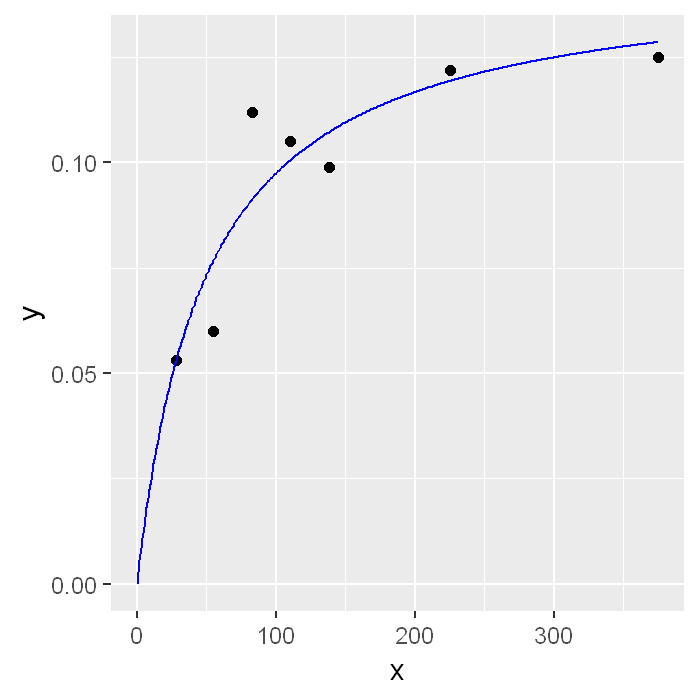

In [16]:
# 生成拟合好的数据
times = seq(0, 375, 1)
df = data.frame(times, Model(sP$par, times))
# 绘图
options(repr.plot.width = 3.5, repr.plot.height = 3.5, repr.plot.res = 200)
Obs %>%
    ggplot(aes(x, y)) +
    geom_point() +
    geom_line(data = df, aes(times,y), color = 'blue')

## 模型校验

### 马尔科夫链蒙特卡洛

number of accepted runs: 1077 out of 3000 (35.9%) 


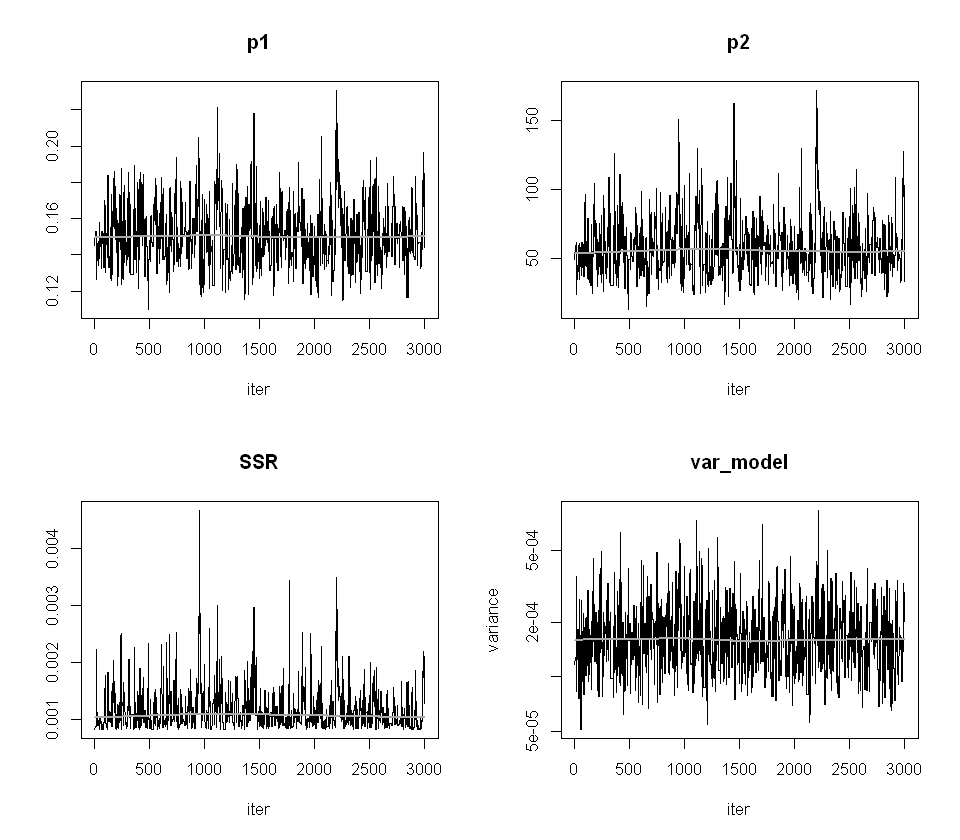

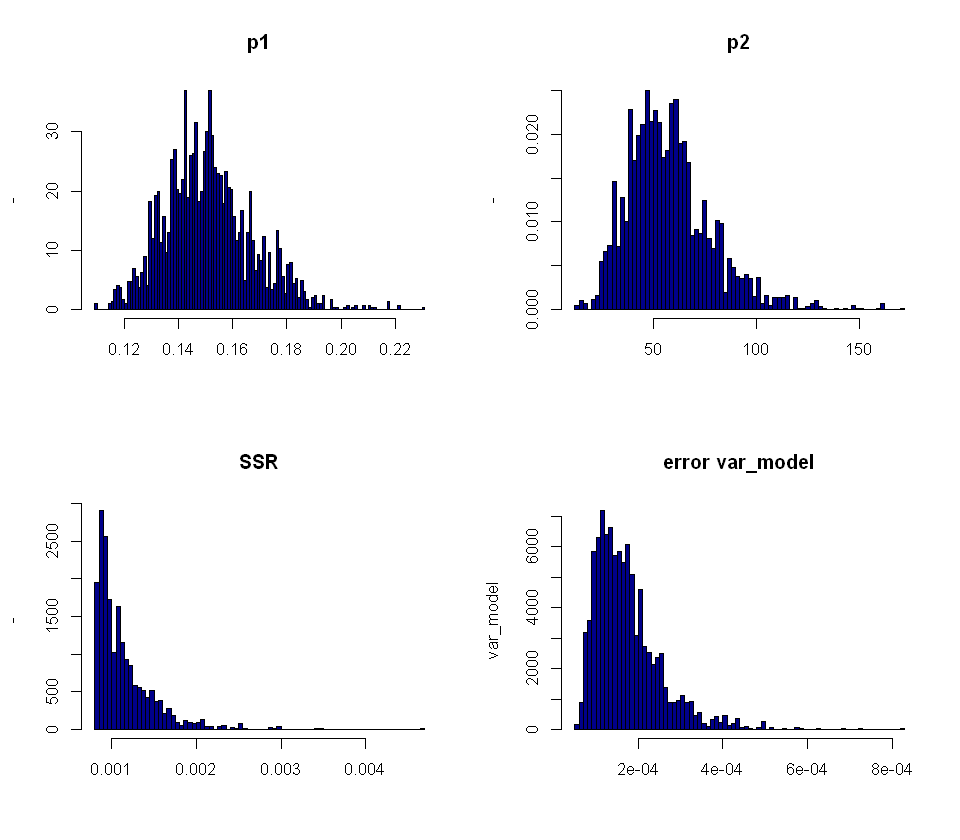

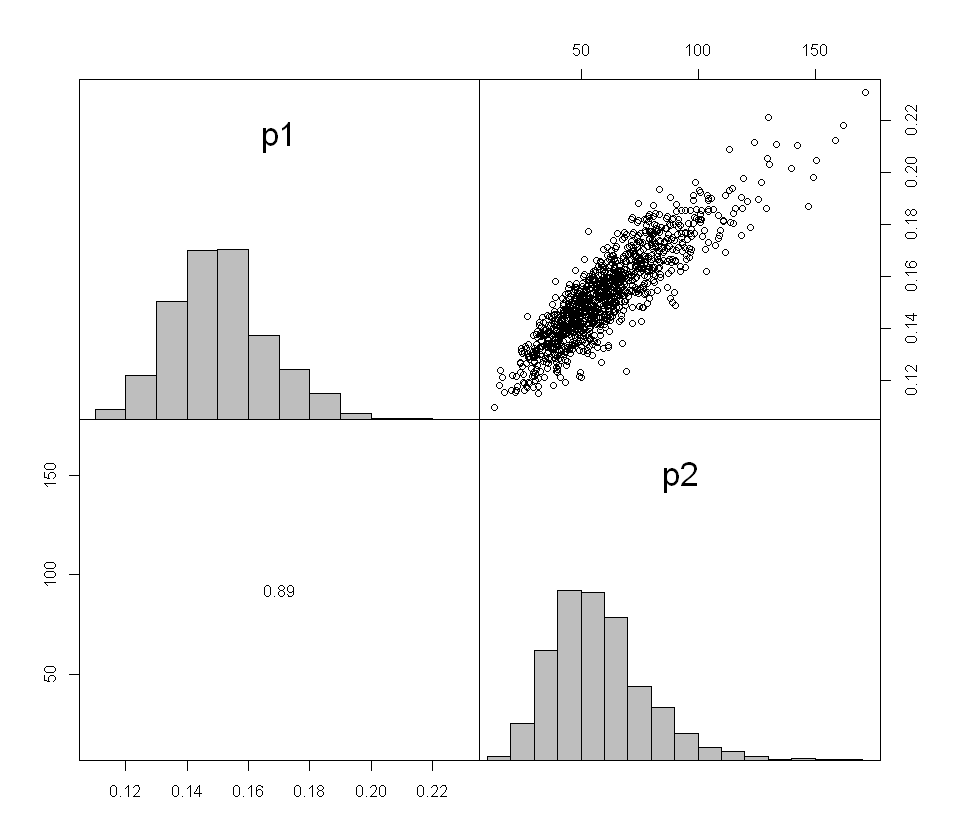

In [31]:
Covar <- sP %>% summary() %>% .$cov.scaled * 2.4^2 / 2
s2prior <- sP %>% summary() %>% .$modVariance
MCMC = modMCMC(
    f = Residuals, p = sP$par,
    jump = Covar, niter = 3000,
    var0 = s2prior, wvar0 = 1, lower = c(0, 0)
)
options(repr.plot.width = 8)
plot(MCMC, Full = TRUE) # 绘制的结果表明链的（接近）收敛。
hist(MCMC, Full = TRUE, col = "darkblue") # 参数的后验分布、平方和和模型的误差标准差。
pairs(MCMC) # 本图展示了两个参数之间的相关性

### 参数不确定性的推断和展示

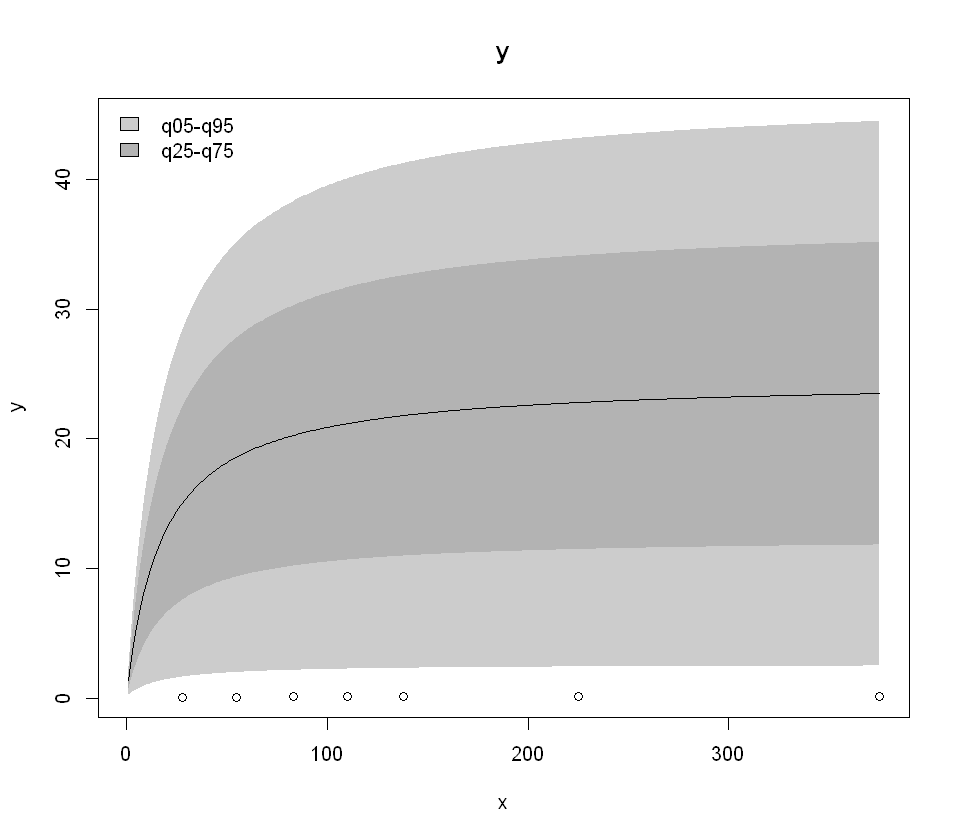

In [36]:
sR = sensRange(parInput = summary(sP) %>% .$par, func = Model, x = 1:375)

plot(summary(sR), quant = TRUE)
points(Obs)

为了更方便进行拟合，在ecmisc中对FME的拟合函数进行了封装。

In [19]:
model = function(x, p) {
    return(p[1] * x / (x + p[2]))
}

model_fit(x = Obs$x, y = Obs$y, fun = model, p = c(1, 1)) %>%
    summary()


Parameters:
     Estimate Std. Error t value Pr(>|t|)    
[1,]  0.14542    0.01564   9.296 0.000242 ***
[2,] 49.05292   17.91195   2.739 0.040862 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01278 on 5 degrees of freedom

Parameter correlation:
       [,1]   [,2]
[1,] 1.0000 0.8926
[2,] 0.8926 1.0000